In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>
# set table border

In [3]:
df = pd.read_csv(r'./data/OD_2018-04.csv') # use . to specify the parent folder of this script
station = pd.read_csv(r'./data/Stations_2018.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236982 entries, 0 to 236981
Data columns (total 6 columns):
start_date            236982 non-null object
start_station_code    236982 non-null int64
end_date              236982 non-null object
end_station_code      236982 non-null int64
duration_sec          236982 non-null int64
is_member             236982 non-null int64
dtypes: int64(4), object(2)
memory usage: 10.8+ MB


In [5]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['start_hour'] = df['start_date'].apply(lambda x:x.hour)
df.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member,start_hour
0,2018-04-10 11:56:00,7030,2018-04-10 11:57,6141,87,1,11
1,2018-04-10 11:56:00,6100,2018-04-10 11:59,6064,122,1,11
2,2018-04-10 11:57:00,6730,2018-04-10 12:16,6396,1132,1,11
3,2018-04-10 11:58:00,6108,2018-04-10 12:02,6114,271,1,11
4,2018-04-10 12:01:00,6223,2018-04-10 12:10,6233,513,1,12


Text(0.5, 1.0, '2018/04')

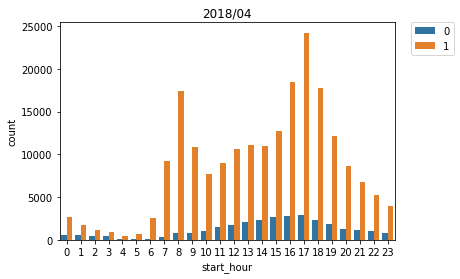

In [6]:
data = df['start_hour']
hue = df['is_member']
sns.countplot(data, hue=hue)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('2018/04')

The above plot showed that if you are a member, you tend to use bixi for work-commute, which is indicated by the two peaks at 8hr and 17hr. This trend is not present in non-members.

In [7]:
# list the 5 most frequently used start_station
df['start_station_code'].value_counts().nlargest(5)

6100    2560
6184    2151
6136    1879
6221    1837
6154    1771
Name: start_station_code, dtype: int64

Text(0.5, 1.0, '2018/04')

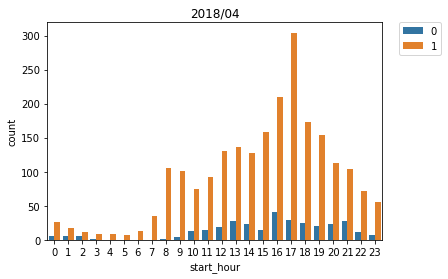

In [8]:
# start_station (6100) with the highest count
data = df[df['start_station_code']==6100]['start_hour']
hue = df['is_member']
sns.countplot(data, hue=hue)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('2018/04')

In [9]:
station.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 4 columns):
code         552 non-null int64
name         552 non-null object
latitude     552 non-null float64
longitude    552 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 17.3+ KB


In [10]:
station.head()

,code,name,latitude,longitude
0,7030,de Bordeaux / Marie-Anne,45.533409,-73.570657
1,6141,de Bordeaux / Rachel,45.532270,-73.568280
2,6100,Mackay / de Maisonneuve,45.496590,-73.578510
3,6064,Métro Peel (de Maisonneuve / Stanley),45.500380,-73.575070
4,6730,35e avenue / Beaubien,45.570081,-73.573047


In [11]:
# select the most frequently used start_station (6100)
station[station['code'] == 6100]

,code,name,latitude,longitude
2,6100,Mackay / de Maisonneuve,45.49659,-73.57851
